## ℹ️ Info

| Method | LB |
| --- | :---: |
| LGBM 5 fold | 0.801 |
| LGBM 15 fold | 0.802 |
| LGBM 15 fold + post-processing | 0.803 |
| LGBM 15 fold + 5 fold Deberta (Ensemble) | 0.807 |
| LGBM 16 fold + 5 fold Deberta (Ensemble) | 0.808 |
| LGBM 15 fold + 5 fold Deberta (Ensemble) + CountVectorizer | 0.810 |
| LGBM 15 fold + 5 fold Deberta (as features) + CountVectorizer | 0.811 |
| LGBM 16 fold + 5 fold Deberta (as features) + CountVectorizer + HashingVectorizer | 0.811 |
| LGBM 15 fold + 5 fold Deberta (as features) + TfidfVectorizer(ngram(3,6)) + CountVectorizer | 0.812 |
| LGBM 15 fold + (new)5 fold Deberta (as features) + TfidfVectorizer(ngram(3,6)) + CountVectorizer(ngram(3,5)) | 0.816 |
| LGBM 15 fold + (new)5 fold Deberta (as features) + TfidfVectorizer(ngram(3,6)) + CountVectorizer(ngram(3,4)) | 0.817 |
| LGBM 15 fold + (new)5 fold Deberta (as features) + more feature engineering + feature selection | 0.818 |


* 2024/04/15 : forked original great work kernels
    * https://www.kaggle.com/code/olyatsimboy/5-fold-deberta-lgbm
    * https://www.kaggle.com/code/aikhmelnytskyy/quick-start-lgbm
    * https://www.kaggle.com/code/hideyukizushi/aes2-5folddeberta-lgbm-countvectorizer-lb-810
    * https://www.kaggle.com/code/olyatsimboy/81-1-aes2-5folddeberta-lgbm-stacking  
    
    
* 2024/04/16 : ~~add HashingVectorizer~~ (not work)
* 2024/04/21 : Add MetaFEs. Train deberta-v3-large local (5Fold SKF) 
    * https://www.kaggle.com/datasets/hideyukizushi/aes2-400-20240419134941    
* 2024/04/22 : change TfidfVectorizer ngram to (3,6), CountVectorizer ngram to (3,5)
* 2024/04/23 : change CountVectorizer ngram to (3,4)
* 2024/04/24 : MORE FEATURE ENGINEERING + FEATURE SELECTION
    * https://www.kaggle.com/code/xianhellg/more-feature-engineering-feature-selection-0-817
---

# <div style="color:white;display:fill;border-radius:5px;background-color:seaGreen;text-align:center;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">▶️ 5 Fold Deberta ◀️</div>

In [1]:
# import pandas as pd 
# from transformers import (
#     AutoTokenizer, 
#     AutoModelForSequenceClassification, 
#     Trainer, 
#     TrainingArguments, 
#     DataCollatorWithPadding
# )
# from datasets import Dataset
# from glob import glob
# import gc
# import torch
# from scipy.special import softmax

# MAX_LENGTH = 1024
# TEST_DATA_PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv"
# MODEL_PATH = '/kaggle/input/aes2-400-20240419134941/*/*'
# EVAL_BATCH_SIZE = 1

# Deberta Model

In [2]:
# models = glob(MODEL_PATH)
# tokenizer = AutoTokenizer.from_pretrained(models[0])

# def tokenize(sample):
#     return tokenizer(sample['full_text'], max_length=MAX_LENGTH, truncation=True)

# df_test = pd.read_csv(TEST_DATA_PATH)
# ds = Dataset.from_pandas(df_test).map(tokenize).remove_columns(['essay_id', 'full_text'])

# args = TrainingArguments(
#     ".", 
#     per_device_eval_batch_size=EVAL_BATCH_SIZE, 
#     report_to="none"
# )

# predictions = []
# for model in models:
#     model = AutoModelForSequenceClassification.from_pretrained(model)
#     trainer = Trainer(
#         model=model, 
#         args=args, 
#         data_collator=DataCollatorWithPadding(tokenizer), 
#         tokenizer=tokenizer
#     )
    
#     preds = trainer.predict(ds).predictions
#     predictions.append(softmax(preds, axis=-1))  
#     del model, trainer
#     torch.cuda.empty_cache()
#     gc.collect()
    
# predicted_score = 0.

# for p in predictions:
#     predicted_score += p
    
# predicted_score /= len(predictions)

In [3]:
# df_test['score'] = predicted_score.argmax(-1) + 1
# df_test.head() 

In [4]:
# df_test[['essay_id', 'score']].to_csv('submission_1.csv', index=False)

# <div style="color:white;display:fill;border-radius:5px;background-color:seaGreen;text-align:center;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">▶️ 15 fold LGBM ◀️</div>

In [1]:
# Importing necessary libraries
import gc
import lightgbm as lgb
from sklearn.ensemble import VotingRegressor
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import spacy
import string
import torch
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier,BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import DMatrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import cohen_kappa_score
from lightgbm import log_evaluation, early_stopping
from sklearn.linear_model import SGDClassifier
import polars as pl
import joblib

In [2]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "kaggle/input/learning-agency-lab-automated-essay-scoring-2/"

# Load training and testing sets, while using \ n \ n character segmentation to list and renaming to paragraph for full_text data
train = pl.read_csv(PATH + "train.csv").with_columns(columns)
test = pl.read_csv(PATH + "test.csv").with_columns(columns)

nlp = spacy.load("en_core_web_sm")
with open('kaggle/input/english-word-hx/words.txt', 'r') as file:
    english_vocab = set(word.strip().lower() for word in file)

# Display the first sample data in the training set
train.head(1)

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people have car where the…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"


# Features engineering

In [24]:
def count_spelling_errors(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_.lower() for token in doc]
    spelling_errors = sum(1 for token in lemmatized_tokens if token not in english_vocab)
    return spelling_errors

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    # Convert words to lowercase
    x = x.lower()
    # Remove HTML
    x = removeHTML(x)
    # Delete strings starting with @
    x = re.sub("@\w+", '',x)
    # Delete Numbers
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    # Delete URL
    x = re.sub("http\w+", '',x)
    # Replace consecutive empty spaces with a single space character
    x = re.sub(r"\s+", " ", x)
    # Replace consecutive commas and periods with one comma and period character
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    # Remove empty characters at the beginning and end
    x = x.strip()
    return x

## Paragraph Features

In [25]:
# paragraph features
def remove_punctuation(text):
    """
    Remove all punctuation from the input text.
    
    Args:
    - text (str): The input text.
    
    Returns:
    - str: The text with punctuation removed.
    """
    # string.punctuation
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def Paragraph_Preprocess(tmp):
    # Expand the paragraph list into several lines of data
    tmp = tmp.explode('paragraph')
    # Paragraph preprocessing
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_pinctuation'))
    tmp = tmp.with_columns(pl.col('paragraph_no_pinctuation').map_elements(count_spelling_errors).alias("paragraph_error_num"))
    # Calculate the length of each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    # Calculate the number of sentences and words in each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)
    return tmp
# feature_eng
paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']
paragraph_fea2 = ['paragraph_error_num'] + paragraph_fea
def Paragraph_Eng(train_tmp):
    num_list = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600]
    num_list2 = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700]
    aggs = [
        # Count the number of paragraph lengths greater than and less than the i-value
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25,49]], 
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea2],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea2],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea2],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in paragraph_fea2],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea2],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea2],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in paragraph_fea2],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in paragraph_fea2],  
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in paragraph_fea2],  
        ]
    
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df


In [ ]:
tmp = Paragraph_Preprocess(train)
train_feats = Paragraph_Eng(tmp)
train_feats['score'] = train['score']
# Obtain feature names
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

## Sentence Feature

In [26]:
# sentence feature
def Sentence_Preprocess(tmp):
    # Preprocess full_text and use periods to segment sentences in the text
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    # Calculate the length of a sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
    # Filter out the portion of data with a sentence length greater than 15
    tmp = tmp.filter(pl.col('sentence_len')>=15)
    # Count the number of words in each sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    
    return tmp
# feature_eng
sentence_fea = ['sentence_len','sentence_word_cnt']
def Sentence_Eng(train_tmp):
    aggs = [
        # Count the number of sentences with a length greater than i
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [0,15,50,100,150,200,250,300] ], 
        *[pl.col('sentence').filter(pl.col('sentence_len') <= i).count().alias(f"sentence_<{i}_cnt") for i in [15,50] ], 
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in sentence_fea],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in sentence_fea], 
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in sentence_fea], 
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df



In [ ]:
tmp = Sentence_Preprocess(train)
# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

## Word Feature

In [27]:
# word feature
def Word_Preprocess(tmp):
    # Preprocess full_text and use spaces to separate words from the text
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    # Calculate the length of each word
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    # Delete data with a word length of 0
    tmp = tmp.filter(pl.col('word_len')!=0)
    
    return tmp
# feature_eng
def Word_Eng(train_tmp):
    aggs = [
        # Count the number of words with a length greater than i+1
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        # other
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df



In [ ]:
tmp = Word_Preprocess(train)
# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

## Vectorizer

In [32]:
# TfidfVectorizer parameter
vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(3,6),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)
# Fit all datasets into TfidfVector,this may cause leakage and overly optimistic CV scores
train_tfid = vectorizer.fit_transform([i for i in train['full_text']])

In [ ]:

# Convert to array
dense_matrix = train_tfid.toarray()
# Convert to dataframe
df = pd.DataFrame(dense_matrix)
# rename features
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(df, on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

In [31]:
vectorizer_cnt = CountVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(2,3),
            min_df=0.10,
            max_df=0.85,
)
train_tfid = vectorizer_cnt.fit_transform([i for i in train['full_text']])


In [ ]:
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

## Deberta predictions to LGBM as features

In [14]:
# add Deberta predictions to LGBM as features
# deberta_oof = joblib.load('/kaggle/input/aes2-400-20240419134941/oof.pkl')
# print(deberta_oof.shape, train_feats.shape)

# for i in range(6):
#     train_feats[f'deberta_oof_{i}'] = deberta_oof[:, i]

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ', len(feature_names))
# train_feats.to_csv('kaggle/input/train_feats.csv',index=False) # save train_feats data
# train_feats.to_pickle('kaggle/input/train_feats.pkl')
train_feats.shape

Features Number:  21899


(17307, 21901)

In [7]:
# train_feats = pd.read_pickle('kaggle/input/train_feats.pkl')
# feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
# print('Features Number: ', len(feature_names))
# train_feats = pd.read_csv('kaggle/input/train_feats.csv') # load train_feats data
# train_feats.shape

Features Number:  21899


(17307, 21901)

In [8]:
# idea from https://www.kaggle.com/code/rsakata/optimize-qwk-by-lgb/notebook#QWK-objective
def quadratic_weighted_kappa(y_true, y_pred):
    if isinstance(y_pred, xgb.QuantileDMatrix):
        # XGB
        y_true, y_pred = y_pred, y_true

        y_true = (y_true.get_label() + a).round()
        y_pred = (y_pred + a).clip(1, 6).round()
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        return 'QWK', qwk
    else:
        # For lgb
        y_true = y_true + a
        y_pred = (y_pred + a).clip(1, 6).round()
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        return 'QWK', qwk, True
    

def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess
a = 2.998
b = 1.092

In [50]:
# Converting the 'text' column to string type and assigning to X
X = train_feats[feature_names].astype(np.float32).values

# Converting the 'score' column to integer type and assigning to y
y_split = train_feats['score'].astype(int).values
y = train_feats['score'].astype(np.float32).values-a

# Feature Selection

In [10]:
def feature_select_wrapper():
    """
    lgm
    :param train
    :param test
    :return
    """
    # Part 1.
    print('feature_select_wrapper...')
    features = feature_names

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    fse = pd.Series(0, index=features)
         
    for train_index, test_index in skf.split(X, y_split):

        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]

        model = lgb.LGBMRegressor(
                    objective = qwk_obj,
                    metrics = 'None',
                    learning_rate = 0.05,
                    max_depth = 5,
                    num_leaves = 10,
                    colsample_bytree=0.3,
                    reg_alpha = 0.7,
                    reg_lambda = 0.1,
                    n_estimators=700,
                    random_state=412,
                    extra_trees=True,
                    class_weight='balanced',
                    verbosity = - 1)

        predictor = model.fit(X_train_fold,
                              y_train_fold,
                              eval_names=['train', 'valid'],
                              eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                              eval_metric=quadratic_weighted_kappa,
                              callbacks=callbacks)
        models.append(predictor)
        predictions_fold = predictor.predict(X_test_fold)
        predictions_fold = predictions_fold + a
        predictions_fold = predictions_fold.clip(1, 6).round()
        predictions.append(predictions_fold)
        f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
        f1_scores.append(f1_fold)

        kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
        kappa_scores.append(kappa_fold)

        cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[x for x in range(1,7)])
        disp.plot()
        plt.show()
        print(f'F1 score across fold: {f1_fold}')
        print(f'Cohen kappa score across fold: {kappa_fold}')

        fse += pd.Series(predictor.feature_importances_, features)  
    
    # Part 4.
    feature_select = fse.sort_values(ascending=False).index.tolist()[:15000] # 不要按照他的这个来，要具体根据confusion matrix来选，不一定选前13000个。
    print('done')
    return feature_select

feature_select_wrapper...
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.703665	valid's QWK: 0.681545
[50]	train's QWK: 0.745037	valid's QWK: 0.725364
[75]	train's QWK: 0.775324	valid's QWK: 0.75262
[100]	train's QWK: 0.790393	valid's QWK: 0.766634
[125]	train's QWK: 0.800952	valid's QWK: 0.774194
[150]	train's QWK: 0.809928	valid's QWK: 0.777618
[175]	train's QWK: 0.818001	valid's QWK: 0.779044
[200]	train's QWK: 0.823246	valid's QWK: 0.784516
[225]	train's QWK: 0.827919	valid's QWK: 0.787477
[250]	train's QWK: 0.831947	valid's QWK: 0.791292
[275]	train's QWK: 0.836393	valid's QWK: 0.793661
[300]	train's QWK: 0.839643	valid's QWK: 0.79656
[325]	train's QWK: 0.842467	valid's QWK: 0.798022
[350]	train's QWK: 0.846135	valid's QWK: 0.79988
[375]	train's QWK: 0.848281	valid's QWK: 0.800045
[400]	train's QWK: 0.850697	valid's QWK: 0.800692
[425]	train's QWK: 0.853738	valid's QWK: 0.80282
[450]	train's 

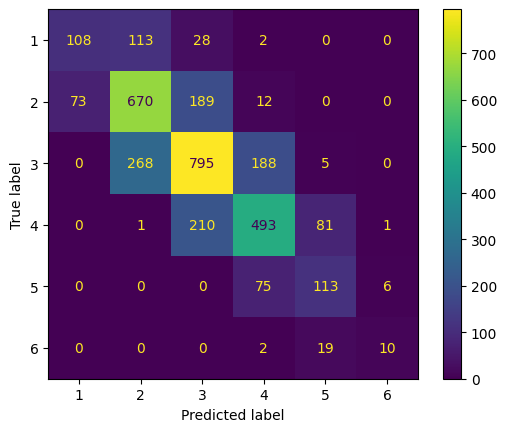

F1 score across fold: 0.6302483149077075
Cohen kappa score across fold: 0.8045187131017388
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.70403	valid's QWK: 0.709233
[50]	train's QWK: 0.745819	valid's QWK: 0.743806
[75]	train's QWK: 0.772145	valid's QWK: 0.763177
[100]	train's QWK: 0.788775	valid's QWK: 0.774783
[125]	train's QWK: 0.800429	valid's QWK: 0.781143
[150]	train's QWK: 0.808289	valid's QWK: 0.78753
[175]	train's QWK: 0.814967	valid's QWK: 0.792099
[200]	train's QWK: 0.821509	valid's QWK: 0.794809
[225]	train's QWK: 0.825945	valid's QWK: 0.796424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	train's QWK: 0.830831	valid's QWK: 0.796169
[275]	train's QWK: 0.834618	valid's QWK: 0.796508
[300]	train's QWK: 0.838815	valid's QWK: 0.797221
[325]	train's QWK: 0.84216	valid's QWK: 0.801445
[350]	train's QWK: 0.845523	valid's QWK: 0.802367
[375]	train's QWK: 0.84

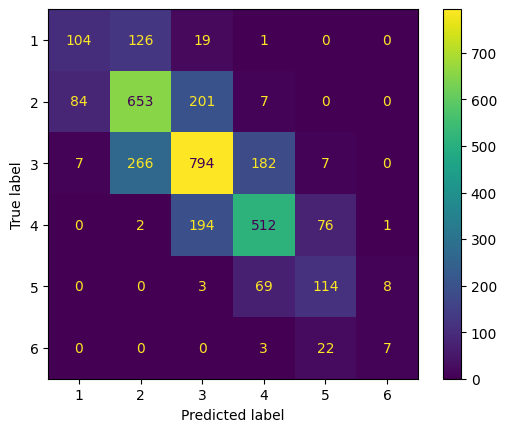

F1 score across fold: 0.6288115374488641
Cohen kappa score across fold: 0.8062729040824297
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.704538	valid's QWK: 0.69205
[50]	train's QWK: 0.746569	valid's QWK: 0.730051
[75]	train's QWK: 0.773809	valid's QWK: 0.751915
[100]	train's QWK: 0.789477	valid's QWK: 0.764328
[125]	train's QWK: 0.801282	valid's QWK: 0.772993
[150]	train's QWK: 0.808291	valid's QWK: 0.78106
[175]	train's QWK: 0.814761	valid's QWK: 0.784971
[200]	train's QWK: 0.821131	valid's QWK: 0.785323
[225]	train's QWK: 0.826299	valid's QWK: 0.788474
[250]	train's QWK: 0.831061	valid's QWK: 0.790069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	train's QWK: 0.835453	valid's QWK: 0.794159
[300]	train's QWK: 0.839384	valid's QWK: 0.796509
[325]	train's QWK: 0.84262	valid's QWK: 0.799052
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

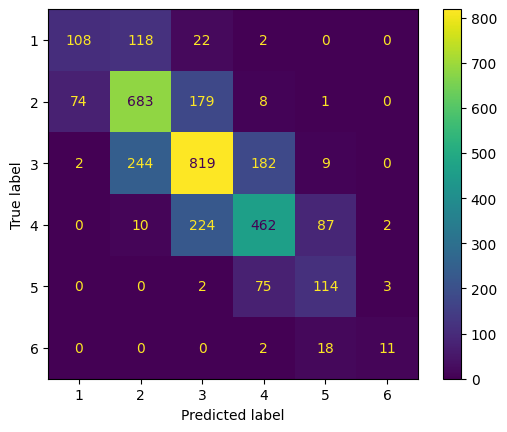

F1 score across fold: 0.632668830682736
Cohen kappa score across fold: 0.801436096727411
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.705817	valid's QWK: 0.695442
[50]	train's QWK: 0.746404	valid's QWK: 0.735792
[75]	train's QWK: 0.776514	valid's QWK: 0.758864
[100]	train's QWK: 0.792503	valid's QWK: 0.775675
[125]	train's QWK: 0.803182	valid's QWK: 0.781815
[150]	train's QWK: 0.811444	valid's QWK: 0.788473
[175]	train's QWK: 0.816483	valid's QWK: 0.791356
[200]	train's QWK: 0.821511	valid's QWK: 0.796047
[225]	train's QWK: 0.827012	valid's QWK: 0.797
[250]	train's QWK: 0.83084	valid's QWK: 0.8013
[275]	train's QWK: 0.8341	valid's QWK: 0.803814
[300]	train's QWK: 0.837874	valid's QWK: 0.804666
[325]	train's QWK: 0.841478	valid's QWK: 0.804112
[350]	train's QWK: 0.845413	valid's QWK: 0.805856
[375]	train's QWK: 0.848407	valid's QWK: 0.805242
[400]	train's QWK: 0.851576	valid's QWK: 0.804865
[425]

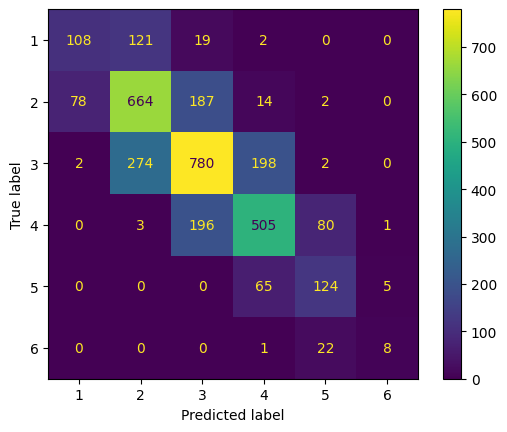

F1 score across fold: 0.6303808768995174
Cohen kappa score across fold: 0.807131568269758
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.697788	valid's QWK: 0.717398
[50]	train's QWK: 0.741203	valid's QWK: 0.747133
[75]	train's QWK: 0.769834	valid's QWK: 0.76608
[100]	train's QWK: 0.786116	valid's QWK: 0.780751
[125]	train's QWK: 0.798483	valid's QWK: 0.790937
[150]	train's QWK: 0.807198	valid's QWK: 0.79584
[175]	train's QWK: 0.814516	valid's QWK: 0.799022
[200]	train's QWK: 0.821236	valid's QWK: 0.802193
[225]	train's QWK: 0.825686	valid's QWK: 0.804708
[250]	train's QWK: 0.829491	valid's QWK: 0.803427
[275]	train's QWK: 0.833038	valid's QWK: 0.805661
[300]	train's QWK: 0.836752	valid's QWK: 0.806457
[325]	train's QWK: 0.839554	valid's QWK: 0.807322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	train's QWK: 0.8434	valid's QWK: 0.808941
[375]	train's QWK: 0.8470

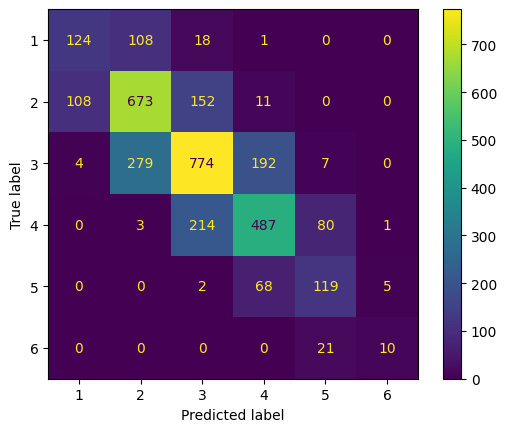

F1 score across fold: 0.6309548996687002
Cohen kappa score across fold: 0.8126030905683984
done


In [11]:
f1_scores = []
kappa_scores = []
models = []
predictions = []
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]
feature_select = feature_select_wrapper()

In [51]:
X = train_feats[feature_select].astype(np.float32).values
print('Features Select Number: ', len(feature_select))  

Features Select Number:  15000


# Model training

In [53]:
from xgboost import DMatrix


class Predictor:
    def __init__(self, models: list):
        self.models = models
    def predict(self, X):
        n_models = len(self.models)
        predicted = None
        for i, model in enumerate(self.models):
            if i == 0: # LightGBM weight
                predicted = 0.4*model.predict(X)
            elif i == 1: # CatBoost weight
                predicted += 0.3*model.predict(X)
            else: # XGBoost weight
                if not isinstance(X, DMatrix):
                    X = xgb.DMatrix(X)
                predicted += 0.3*model.predict(X)
                    
        return predicted

Running on GPU


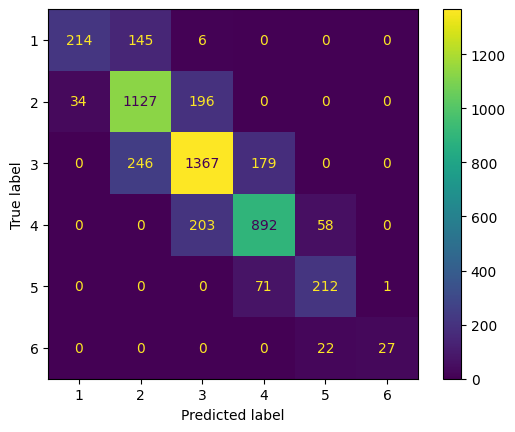

F1 score across fold: 0.7666197507314237
Cohen kappa score across fold: 0.8887854366010203


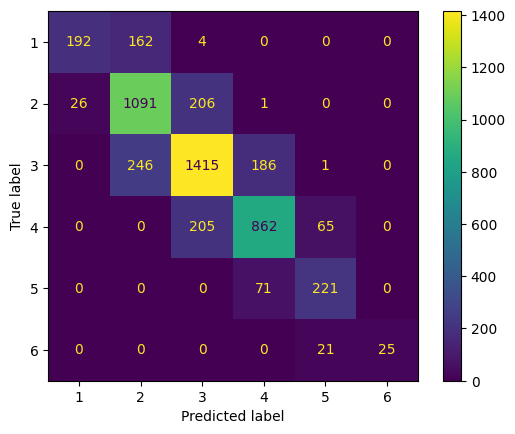

F1 score across fold: 0.7596107914734462
Cohen kappa score across fold: 0.8835597781809932


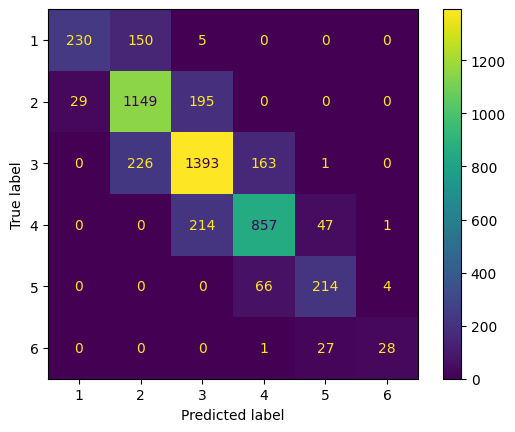

F1 score across fold: 0.7728445190911283
Cohen kappa score across fold: 0.8926529080653064


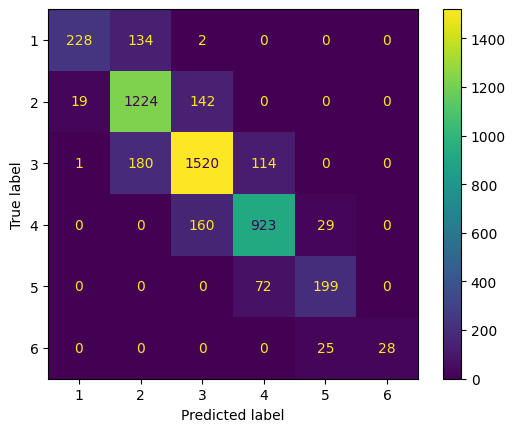

F1 score across fold: 0.8228225155542365
Cohen kappa score across fold: 0.9145208542132449


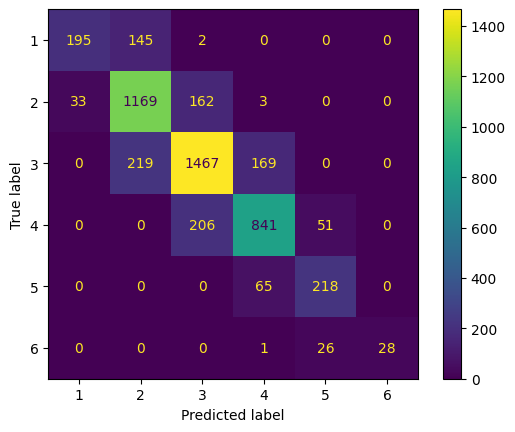

F1 score across fold: 0.7818318896199762
Cohen kappa score across fold: 0.8941803339499349


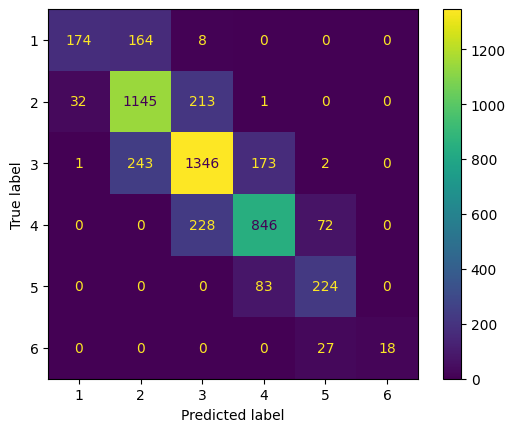

F1 score across fold: 0.7480529105207467
Cohen kappa score across fold: 0.8776585567989269


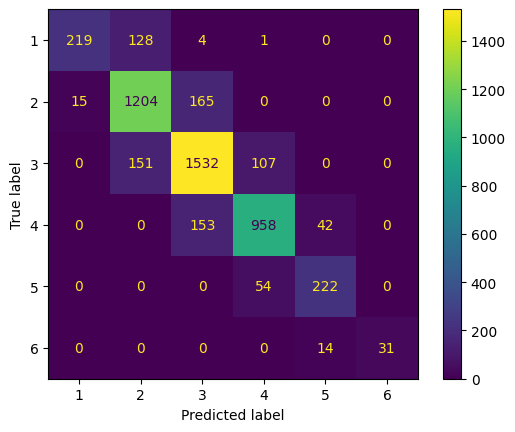

F1 score across fold: 0.8320869375491653
Cohen kappa score across fold: 0.9176148483742766


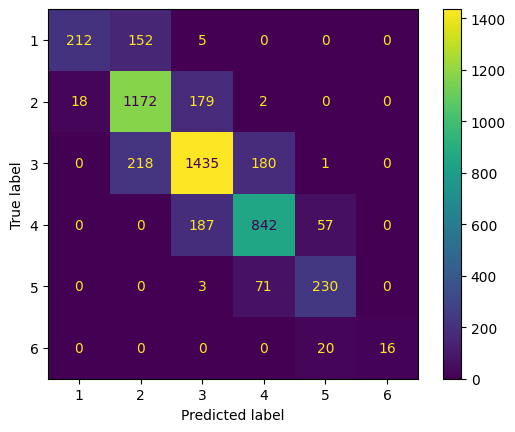

F1 score across fold: 0.779683965538262
Cohen kappa score across fold: 0.891482008430171


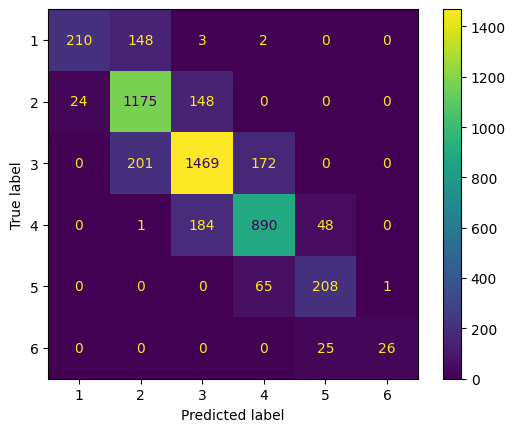

F1 score across fold: 0.793773779300152
Cohen kappa score across fold: 0.8991547090083196


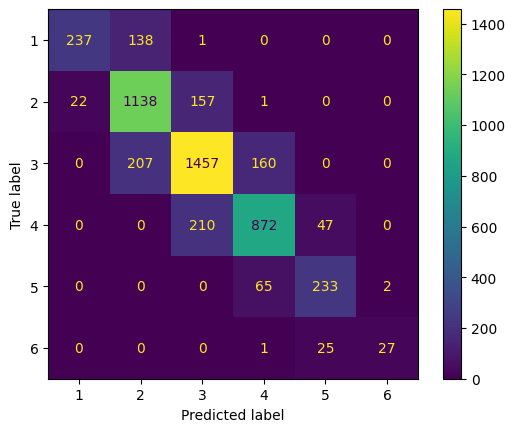

F1 score across fold: 0.7915899895680445
Cohen kappa score across fold: 0.90244654724257


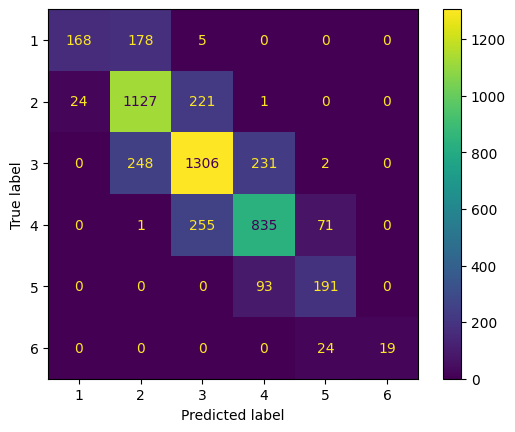

F1 score across fold: 0.726448051824638
Cohen kappa score across fold: 0.8653270495058156


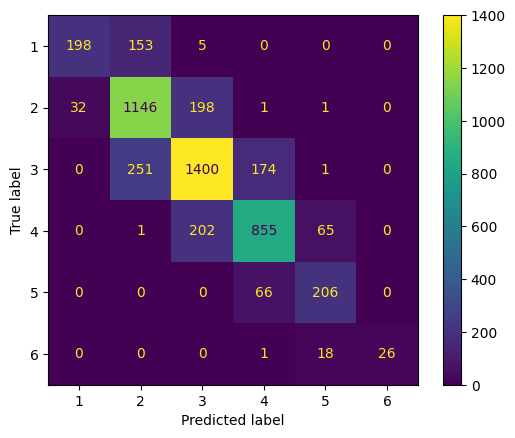

F1 score across fold: 0.7648003182177917
Cohen kappa score across fold: 0.8837247392961862


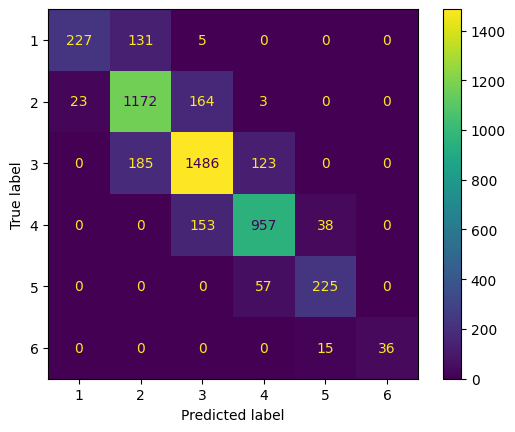

F1 score across fold: 0.8196829601410113
Cohen kappa score across fold: 0.9130852242691874


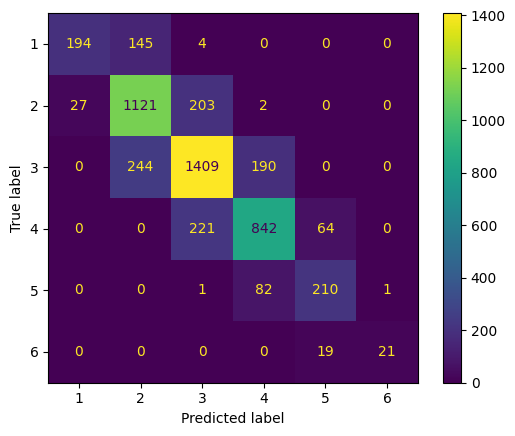

F1 score across fold: 0.7579978614422086
Cohen kappa score across fold: 0.8806201385867547


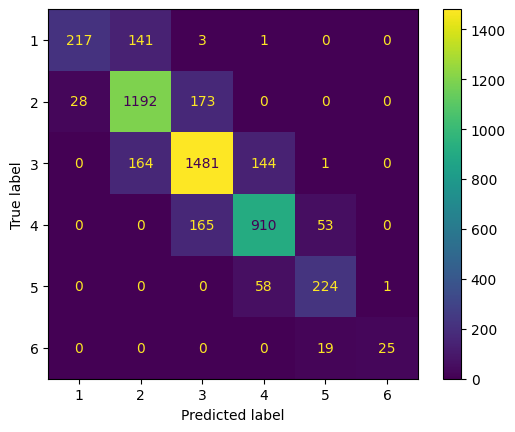

F1 score across fold: 0.808384702661973
Cohen kappa score across fold: 0.9073958146646729


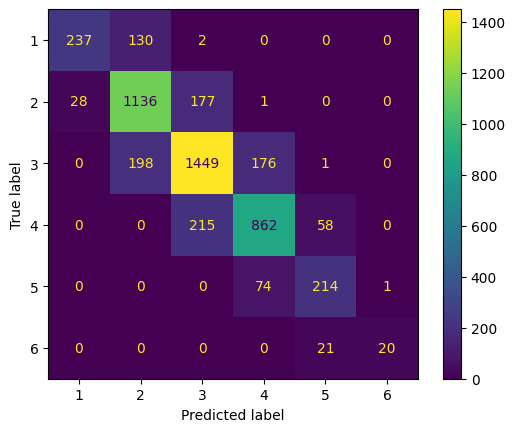

F1 score across fold: 0.7826060233454323
Cohen kappa score across fold: 0.895386606731671


In [54]:
LOAD = False # re-train
# Define the number of splits for cross-validation
n_splits = 16
models = []
device = 'GPU' if torch.cuda.is_available() else 'CPU'
print(f"Running on {device}")

if not LOAD:
    for i in range(n_splits):
        random_indices = np.random.choice(X.shape[0], size=5000, replace=False)
        random_test_X = X[random_indices, :]
        random_test_y = y_split[random_indices]
        lgb_predictor = lgb.Booster(model_file=f'kaggle/input/aes-lgbm/fold_{i+1}.txt')
        cat_model = CatBoostRegressor()
        cat_model.load_model(f'kaggle/input/aes-catboost/fold_{i+1}.cbm')
        xgb_regressor = xgb.Booster()
        xgb_regressor.load_model(f'kaggle/input/aes-xgboost/fold_{i+1}.bin')

        predictor = Predictor([lgb_predictor, cat_model, xgb_regressor])
        
        models.append(predictor)
        
        # # Make predictions on the test data for this fold
        #         # Make predictions on the test data for this fold
        # predictions_fold = predictor.predict(random_test_X)
        # predictions_fold = predictions_fold + a
        # predictions_fold = predictions_fold.clip(1, 6).round().astype(int)
        
        # # Confusion Matrix for each fold
        # cm = confusion_matrix(random_test_y, predictions_fold, labels=[x for x in range(1,7)])
        # disp = ConfusionMatrixDisplay(confusion_matrix=cm,
        #                               display_labels=[x for x in range(1,7)])
        # disp.plot()
        # plt.show()
        
        # # Calculate and store the F1 score for this fold
        # f1_fold = f1_score(random_test_y, predictions_fold, average='weighted')
        # f1_scores.append(f1_fold)

        # # Calculate and store the Cohen's kappa score for this fold
        # kappa_fold = cohen_kappa_score(random_test_y, predictions_fold, weights='quadratic')
        # kappa_scores.append(kappa_fold)

        # print(f'F1 score across fold: {f1_fold}')
        # print(f'Cohen kappa score across fold: {kappa_fold}')
        # gc.collect()
else:
    # Initialize StratifiedKFold with the specified number of splits
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    # Lists to store scores
    f1_scores = []
    kappa_scores = []
    models = []
    predictions = []
    callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]
    # Loop through each fold of the cross-validation
    i=1
    for train_index, test_index in skf.split(X, y_split):
        # Split the data into training and testing sets for this fold
        print('\nFold_{} Training ================================\n'.format(i))
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]

        # LGBM
        lgb_model = lgb.LGBMRegressor(
                    objective = qwk_obj,
                    metrics = 'None',
                    learning_rate = 0.05,
                    max_depth = 5,
                    num_leaves = 10,
                    colsample_bytree=0.3,
                    reg_alpha = 0.7,
                    reg_lambda = 0.1,
                    n_estimators=700,
                    random_state=42,
                    extra_trees=True,
                    class_weight='balanced',
                    # device='gpu',
                    verbosity = - 1)

        # Fit the model on the training data for this fold  
        lgb_predictor = lgb_model.fit(X_train_fold,
                              y_train_fold,
                              eval_names=['train', 'valid'],
                              eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                              eval_metric=quadratic_weighted_kappa,
                              callbacks=callbacks
                             )

        lgb_predictor.booster_.save_model(f'kaggle/out/aes-lgbm/fold_{i}.txt')
        print('\nFold_{} LightGBM Model saved.\n'.format(i))


        
        
        # CAT
        cat_model = CatBoostRegressor(
            iterations=1000,
            learning_rate = 0.1,
            depth = 5,
            bootstrap_type='Bernoulli',
            subsample=0.8,
            l2_leaf_reg = 1,
            task_type = 'GPU',
            devices= '6:7:8',
            objective = 'RMSE',
            eval_metric = 'RMSE',
            loss_function="RMSE")
        train_pool = Pool(data = X_train_fold, label = y_train_fold)
        valid_pool = Pool(data = X_test_fold, label = y_test_fold)

        cat_model.fit(train_pool,
                    verbose=100,
                    eval_set=valid_pool,
                    early_stopping_rounds=75
                    )
        
        cat_model.save_model(f'kaggle/out/aes-catboost/fold_{i}.cbm')
        print('\nFold_{} CatBoost Model saved.\n'.format(i))
        
        # XGB
        
        xgb_regressor = xgb.XGBRegressor(
            objective = qwk_obj,
            metrics = 'None',
            learning_rate = 0.1,
            max_depth = 8,
            num_leaves = 10,
            colsample_bytree=0.5,
            reg_alpha = 1.0,
            reg_lambda = 0.1,
            n_estimators=1024,
            random_state=42,
            extra_trees=True,
            class_weight='balanced',
            tree_method="gpu_hist",
            gpu_id = 5
        )
    
        xgb_callbacks = [
            xgb.callback.EvaluationMonitor(period=100),
            xgb.callback.EarlyStopping(75, metric_name="QWK", maximize=True, save_best=True)
        ]
        xgb_regressor.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
            eval_metric=quadratic_weighted_kappa,
            callbacks=xgb_callbacks
        )
        xgb_regressor.save_model(f'kaggle/out/aes-xgboost/fold_{i}.bin')
        print('\nFold_{} XGBoost Model saved.\n'.format(i)) 
        
        # Ensemble
        
        predictor = Predictor([lgb_predictor, cat_model, xgb_regressor])
        
        models.append(predictor)
        # Make predictions on the test data for this fold
        predictions_fold = predictor.predict(X_test_fold)
        predictions_fold = predictions_fold + a
        predictions_fold = predictions_fold.clip(1, 6).round()
        predictions.append(predictions_fold)
        
        # Confusion Matrix for each fold
        cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[x for x in range(1,7)])
        disp.plot()
        plt.show()
        
        # Calculate and store the F1 score for this fold
        f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
        f1_scores.append(f1_fold)

        # Calculate and store the Cohen's kappa score for this fold
        kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
        kappa_scores.append(kappa_fold)

        print(f'F1 score across fold: {f1_fold}')
        print(f'Cohen kappa score across fold: {kappa_fold}')
        i+=1
        gc.collect()


In [22]:
if not LOAD:
    print(f'Mean F1 score across {n_splits} folds: 0.6694070084827064')
    print(f'Mean Cohen kappa score across {n_splits} folds: 0.835342584985933')
else:
    # Calculate the mean scores across all folds
    mean_f1_score = np.mean(f1_scores)
    mean_kappa_score = np.mean(kappa_scores)
    # Print the mean scores
    print(f'Ensemble Mean F1 score across {n_splits} folds: {mean_f1_score}')
    print(f'Ensemble Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

Ensemble Mean F1 score across 16 folds: 0.6378690655912214
Ensemble Mean Cohen kappa score across 16 folds: 0.801045883419563


# Inference

In [34]:
# Paragraph
tmp = Paragraph_Preprocess(test)
test_feats = Paragraph_Eng(tmp)
# Sentence
tmp = Sentence_Preprocess(test)
test_feats = test_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
# Word
tmp = Word_Preprocess(test)
test_feats = test_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

# TfidfVectorizer
test_tfid = vectorizer.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# CountVectorizer
test_tfid = vectorizer_cnt.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# for i in range(6):
#     test_feats[f'deberta_oof_{i}'] = predicted_score[:, i]

# Features number
feature_names = list(filter(lambda x: x not in ['essay_id','score'], test_feats.columns))
print('Features number: ',len(feature_names))
test_feats.head(3)

/tmp/ipykernel_1860926/1122620497.py:20: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
/tmp/ipykernel_1860926/1122620497.py:21: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_pinctuation'))
/tmp/ipykernel_1860926/1122620497.py:22: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph_no_pinctuation').map_elements(count_spelling_errors).alias("paragraph_error_num"))


Features number:  21899


/tmp/ipykernel_1860926/1122620497.py:24: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
/tmp/ipykernel_1860926/3643046146.py:7: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable resul

,essay_id,paragraph_0_cnt,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,...,tfid_cnt_2160,tfid_cnt_2161,tfid_cnt_2162,tfid_cnt_2163,tfid_cnt_2164,tfid_cnt_2165,tfid_cnt_2166,tfid_cnt_2167,tfid_cnt_2168,tfid_cnt_2169
0,000d118,1,1,1,1,1,1,1,1,1,...,3,0,0,0,0,0,0,0,0,0
1,000fe60,5,5,5,5,5,5,5,4,3,...,2,0,0,1,1,0,0,0,0,0
2,001ab80,4,4,4,4,4,4,4,4,4,...,1,0,2,0,0,0,0,0,0,0


# Submission

In [35]:
probabilities = []
for model in models:
    proba = model.predict(test_feats[feature_select]) + a
    probabilities.append(proba)
    
# Compute the average probabilities across all models
predictions = np.mean(probabilities, axis=0)
predictions = np.round(predictions.clip(1, 6))

# Print the predictions
print(predictions)

[2. 3. 4.]


In [37]:
submission = pd.read_csv("kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
submission['score'] = predictions
submission['score'] = submission['score'].astype(int)
submission.to_csv("kaggle/out/submission.csv", index=None)
display(submission.head())

,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4


# <div style="color:white;display:fill;border-radius:5px;background-color:seaGreen;text-align:center;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">▶️ Ensemble ◀️</div>

In [ ]:
# # Load the data
# df1 = pd.read_csv('/kaggle/working/submission_1.csv')
# df2 = pd.read_csv('/kaggle/working/submission_2.csv')

# # Merging the dataframes on 'essay_id'
# df = pd.merge(left=df1, right=df2, on='essay_id', suffixes=('_1', '_2'))

# # Calculating the average score directly without apply()
# df['score'] = ((df['score_1'] + df['score_2']) / 2).round().astype(int)

# # Saving the desired columns to a new csv file
# df[['essay_id', 'score']].to_csv('submission.csv', index=False)